In [1]:
from sklearn.datasets import make_blobs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from trustyai.model import Model, feature, output, feature_domain
from trustyai.explainers import CounterfactualExplainer, LimeExplainer, SHAPExplainer
from sklearn import datasets
from sklearn.model_selection import train_test_split
import xgboost

SLF4J: Failed to load class "org.slf4j.impl.StaticLoggerBinder".
SLF4J: Defaulting to no-operation (NOP) logger implementation
SLF4J: See http://www.slf4j.org/codes.html#StaticLoggerBinder for further details.


In [2]:
X, y = make_blobs(n_samples=2000, n_features=2, random_state=0, centers=[(-5,0), (0, 5), (5, 0)])

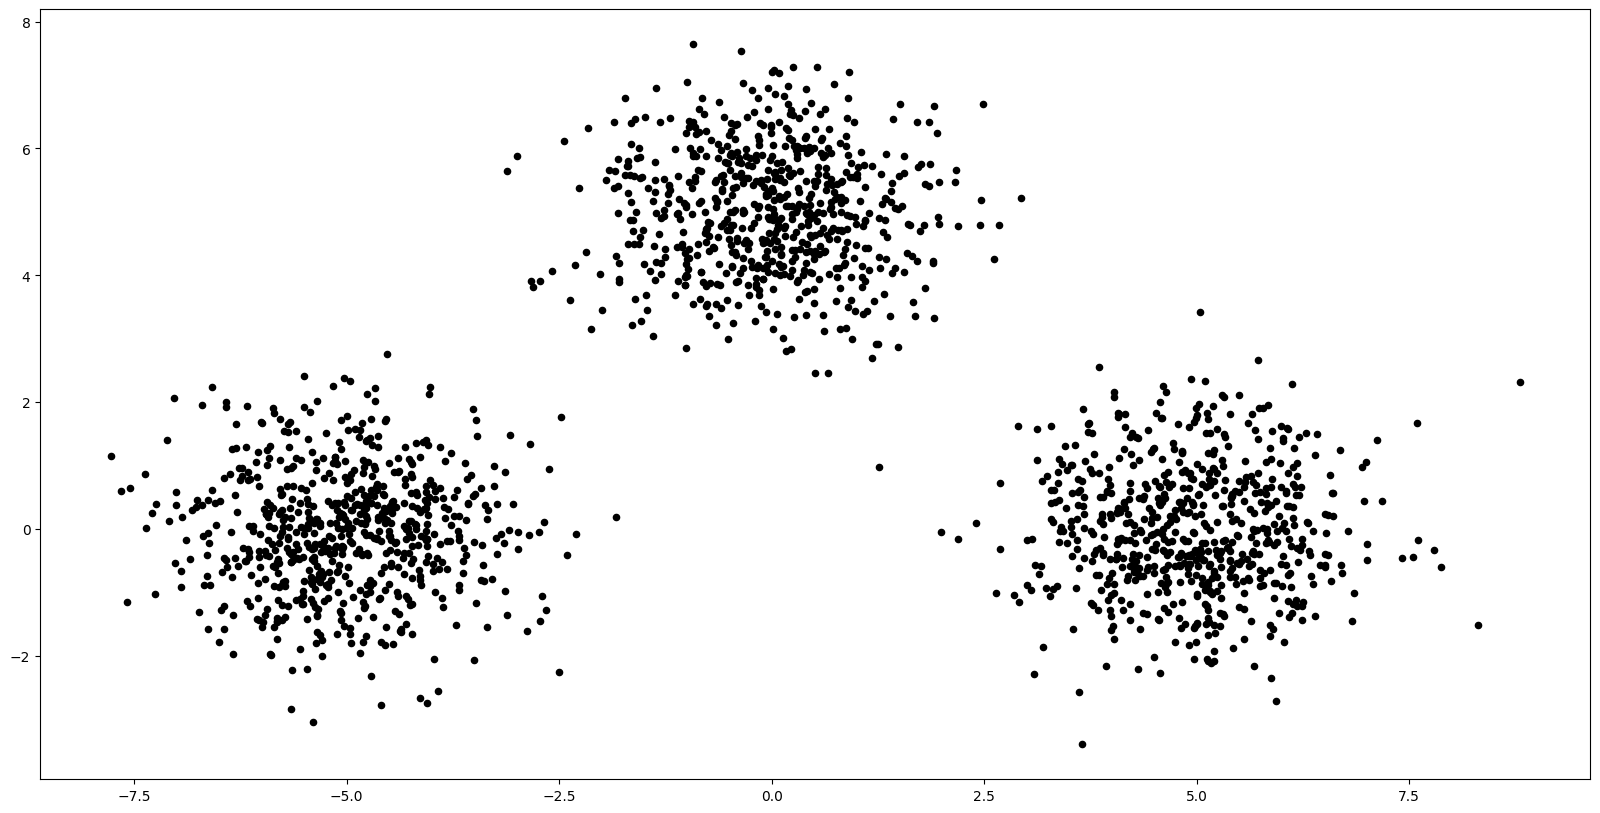

In [3]:
plt.figure(figsize=(20,10))
plt.scatter(X[:,0], X[:,1], c='k', s=20)
plt.show()

In [4]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X,y)

KNeighborsClassifier(n_neighbors=3)

In [5]:
predictions = knn.predict(X)

/Users/rui/.virtualenvs/trustyai-odh-notebook-demo/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


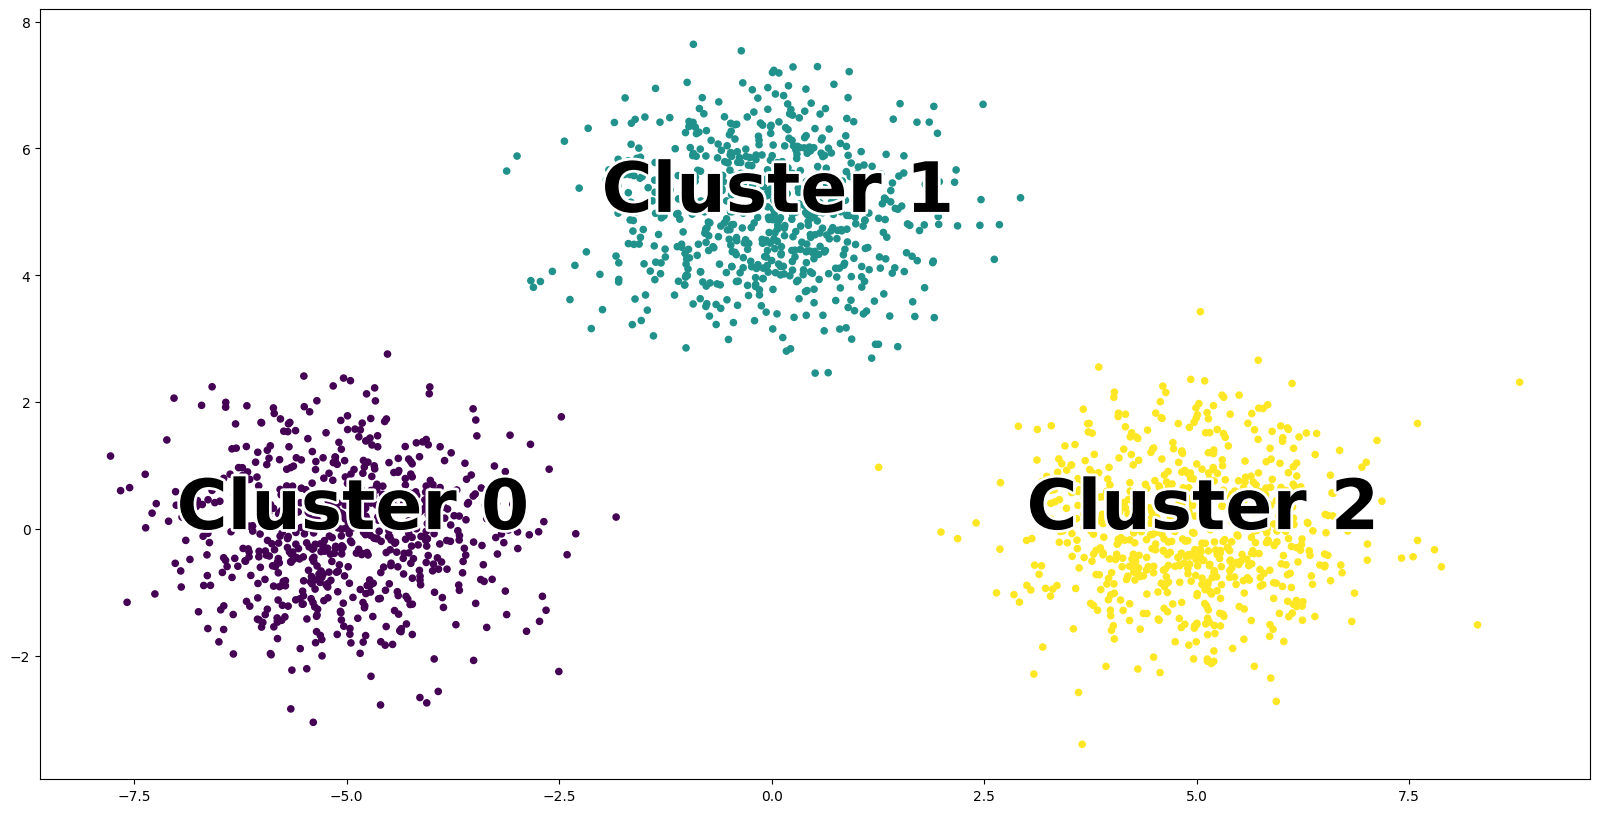

In [6]:
import matplotlib.patheffects as pe

plt.figure(figsize=(20,10))
plt.scatter(X[:,0], X[:,1], c=predictions, s=20)
plt.annotate("Cluster 0", [-7, 0], fontsize=50, weight="bold", 
            color="k",
            path_effects=[pe.withStroke(linewidth=4, foreground="white")])
plt.annotate("Cluster 1", [-2, 5], fontsize=50, weight="bold", 
            color="k",
            path_effects=[pe.withStroke(linewidth=4, foreground="white")])
plt.annotate("Cluster 2", [3, 0], fontsize=50, weight="bold", 
            color="k",
            path_effects=[pe.withStroke(linewidth=4, foreground="white")])

plt.show()

In [7]:
P = np.array([[2.5, -1.0]])

In [8]:
cluster = knn.predict(P)
print(f"Point P ({P}) classified as in cluster {cluster}")

Point P ([[ 2.5 -1. ]]) classified as in cluster [2]


/Users/rui/.virtualenvs/trustyai-odh-notebook-demo/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


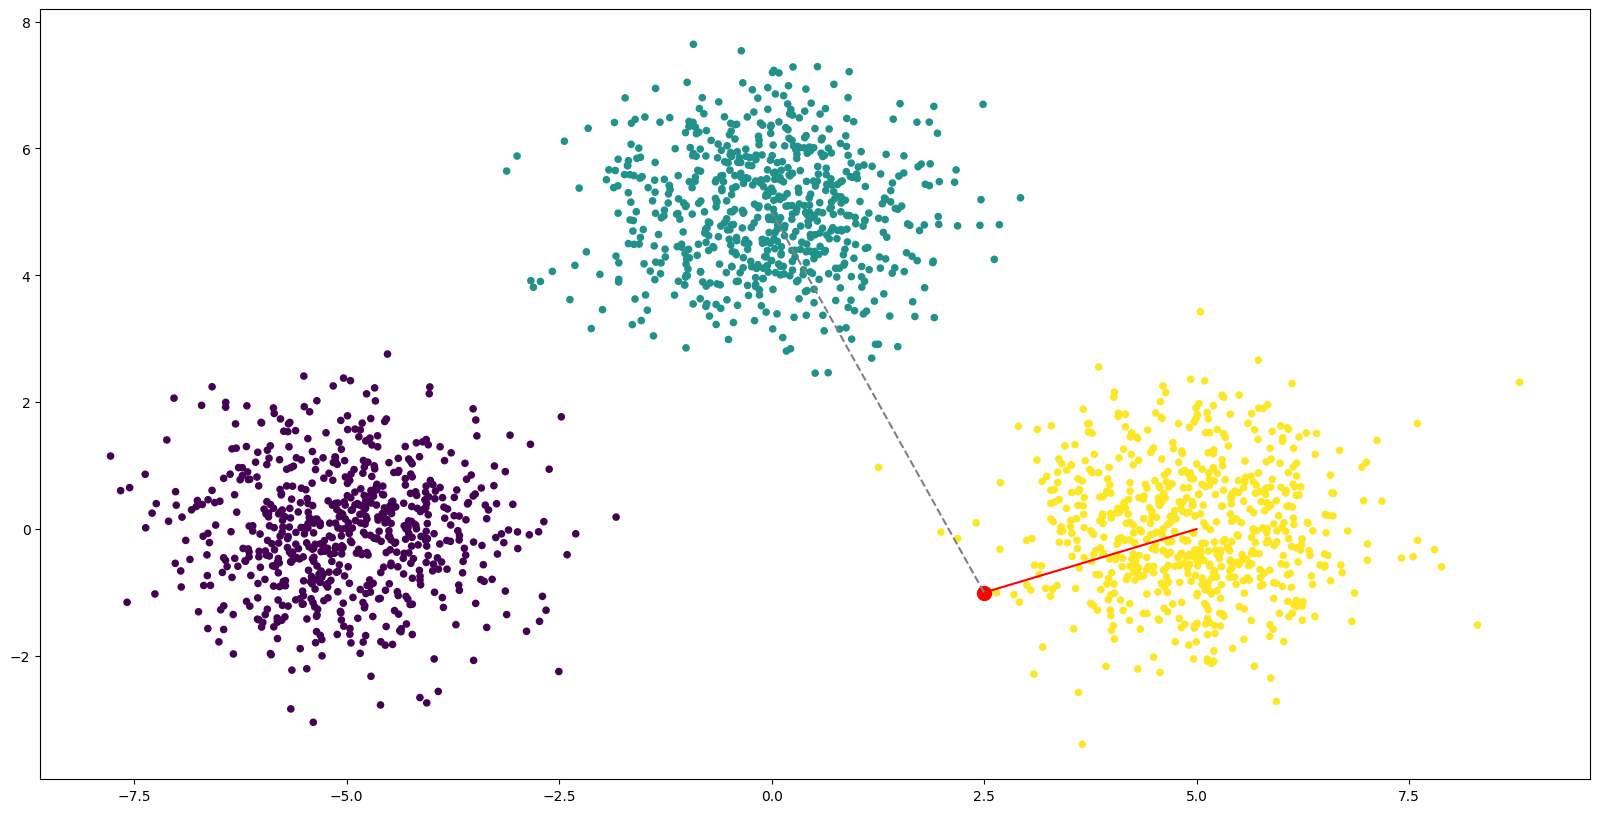

In [9]:
plt.figure(figsize=(20,10))
plt.scatter(X[:,0], X[:,1], c=predictions, s=20)
plt.scatter(P[0][0], P[0][1], c="red", s=100)
plt.plot([P[0][0], 5], [P[0][1], 0], c="red")
plt.plot([P[0][0], 0], [P[0][1], 5], c="grey", linestyle="dashed")
plt.show()

In [10]:
model = Model(knn.predict, output_names=['cluster'])

In [11]:
from trustyai.model import output

goal = [output(name="cluster", dtype="number", value=1)]

In [12]:
features = [
    feature("x", "number", P[0][0], (-10, 10)), 
    feature("y", "number", P[0][1], (-10, 10))
]

In [13]:
counterfactual = CounterfactualExplainer(steps=10_000)

In [14]:
explanation = counterfactual.explain(inputs=features, goal=goal, model=model)

/Users/rui/.virtualenvs/trustyai-odh-notebook-demo/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/rui/.virtualenvs/trustyai-odh-notebook-demo/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will 

In [15]:
cf_P = explanation.proposed_features_array
cf_P

array([[2.49380669, 2.46489674]])

In [16]:
prediction = model(cf_P)
prediction

/Users/rui/.virtualenvs/trustyai-odh-notebook-demo/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


array([1])

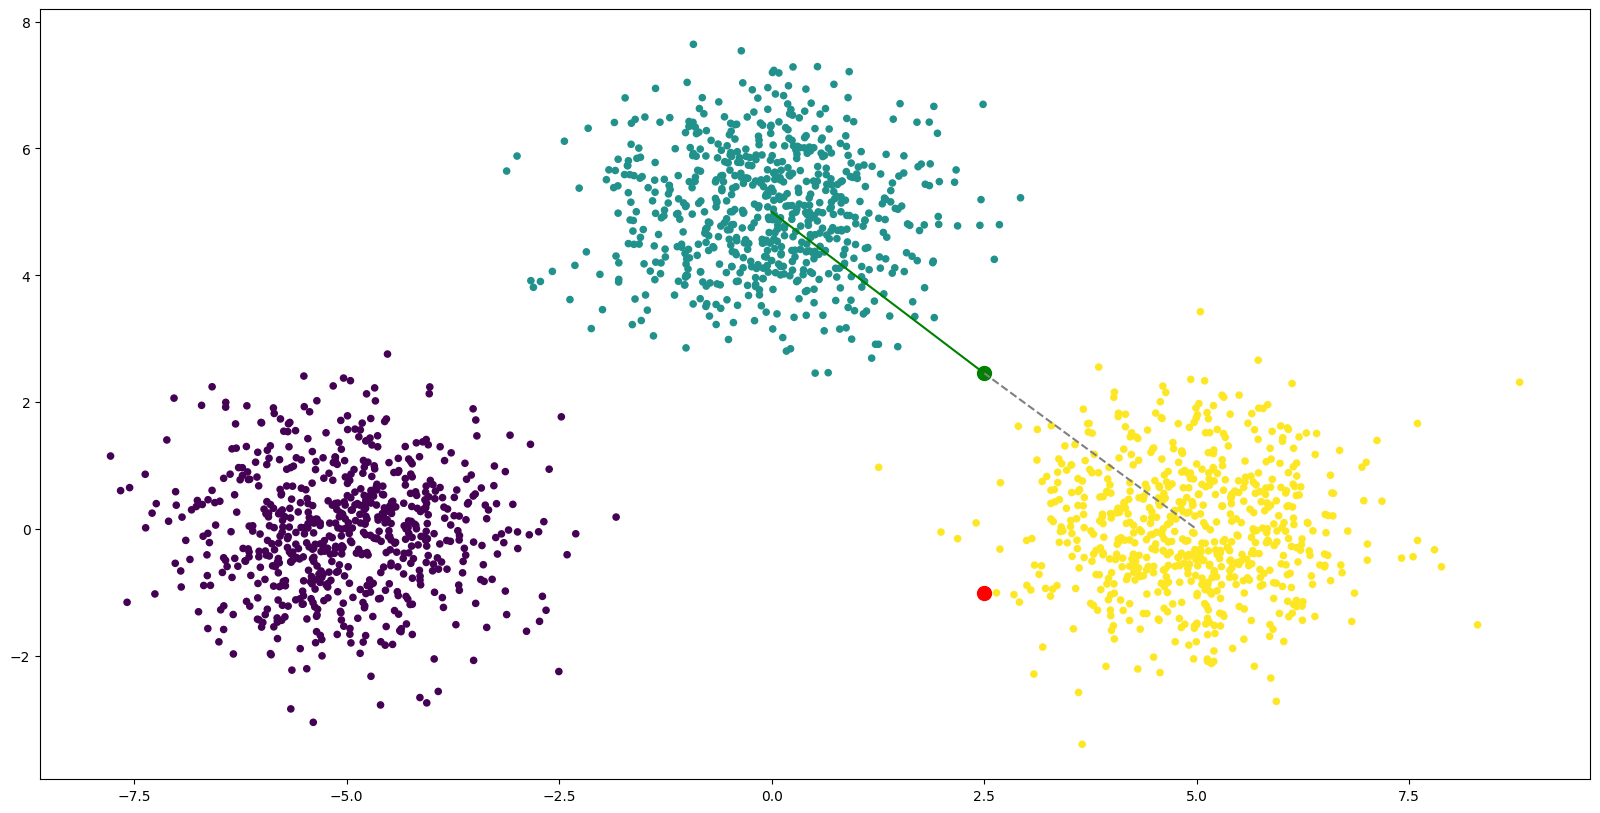

In [17]:
plt.figure(figsize=(20,10))
plt.scatter(X[:,0], X[:,1], c=predictions, s=20)
plt.scatter(P[0][0], P[0][1], c="red", s=100)
plt.scatter(cf_P[0][0], cf_P[0][1], c="green", s=100)
plt.plot([cf_P[0][0], 5], [cf_P[0][1], 0], c="grey", linestyle="dashed")
plt.plot([cf_P[0][0], 0], [cf_P[0][1], 5], c="green")
plt.show()

In [18]:
explanation.as_dataframe()

features  proposed  original  constrained  difference
0        x  2.493807       2.5        False   -0.006193
1        y  2.464897      -1.0        False    3.464897

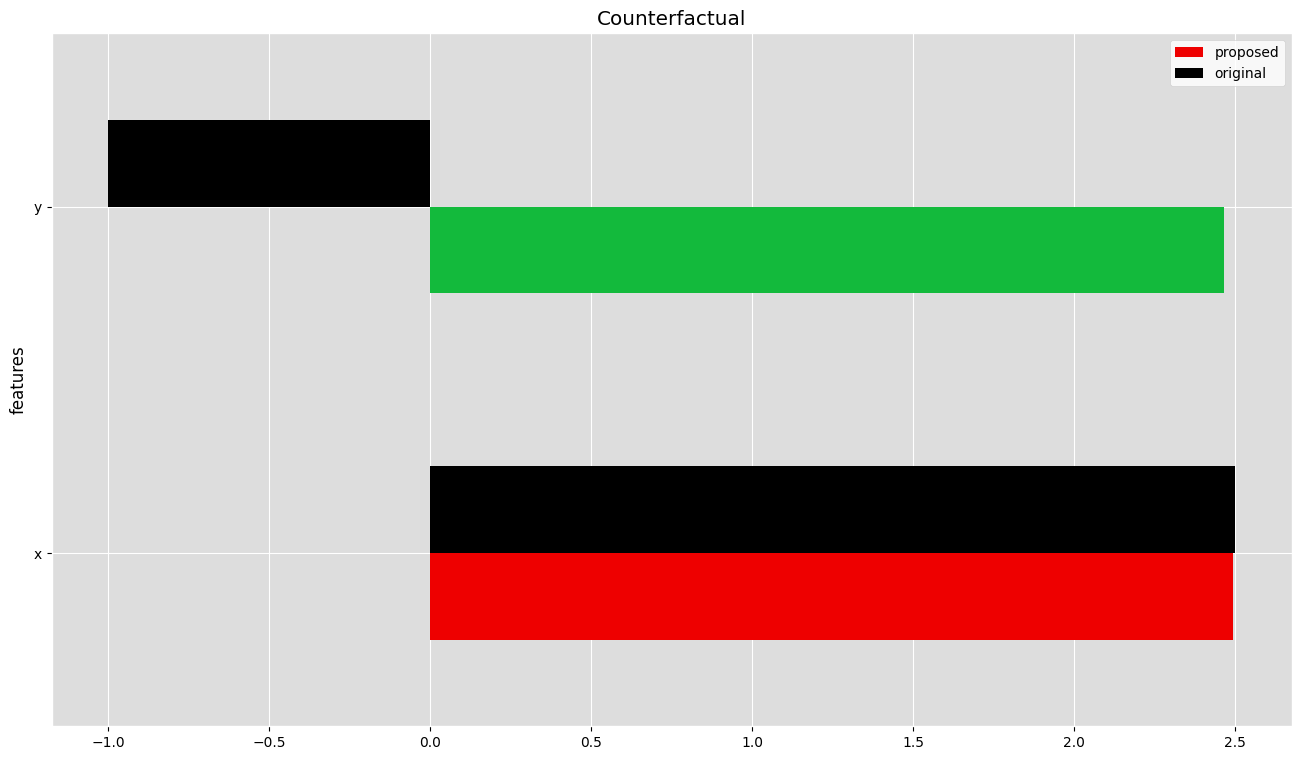

In [19]:
explanation.plot()

In [20]:
lime = LimeExplainer(samples=100)

In [21]:
explanation = lime.explain(inputs=cf_P, outputs=prediction, model=model)

/Users/rui/.virtualenvs/trustyai-odh-notebook-demo/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/rui/.virtualenvs/trustyai-odh-notebook-demo/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will 

In [22]:
explanation.as_dataframe()['cluster']

Feature     Value  Saliency  Confidence
0  input-0  2.493807  0.846048         0.0
1  input-1  2.464897  0.878763         0.0

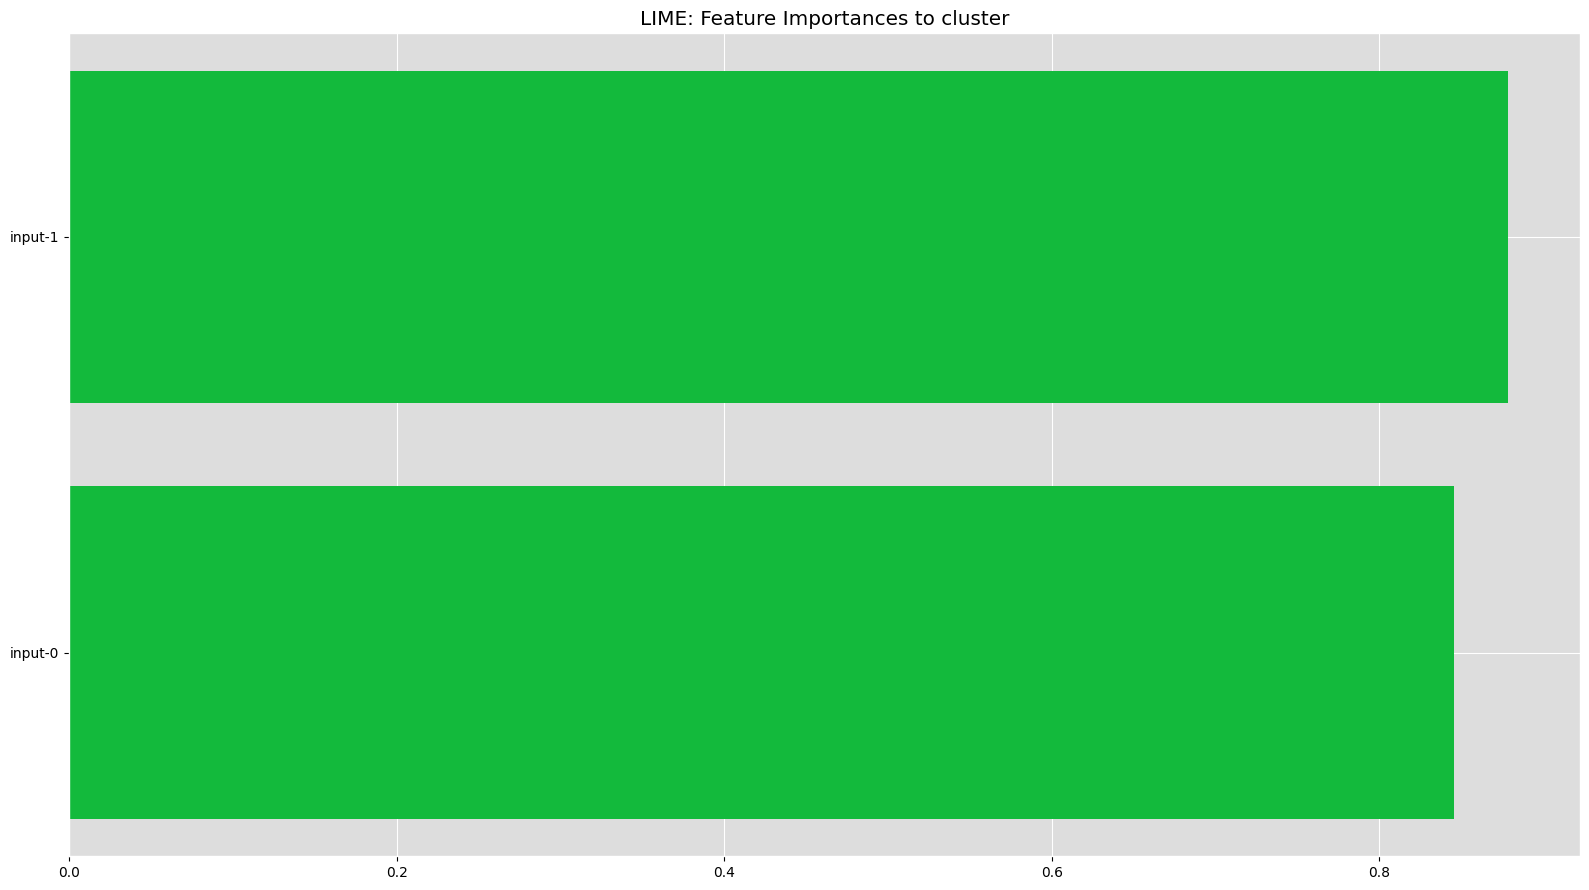

In [23]:
explanation.plot("cluster")

In [24]:
shap = SHAPExplainer(background=X[:100])

In [25]:
explanations = shap.explain(inputs=cf_P, 
                                 outputs=prediction,
                                 model=model)

/Users/rui/.virtualenvs/trustyai-odh-notebook-demo/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/rui/.virtualenvs/trustyai-odh-notebook-demo/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will 

In [26]:
explanations.as_html()['cluster']

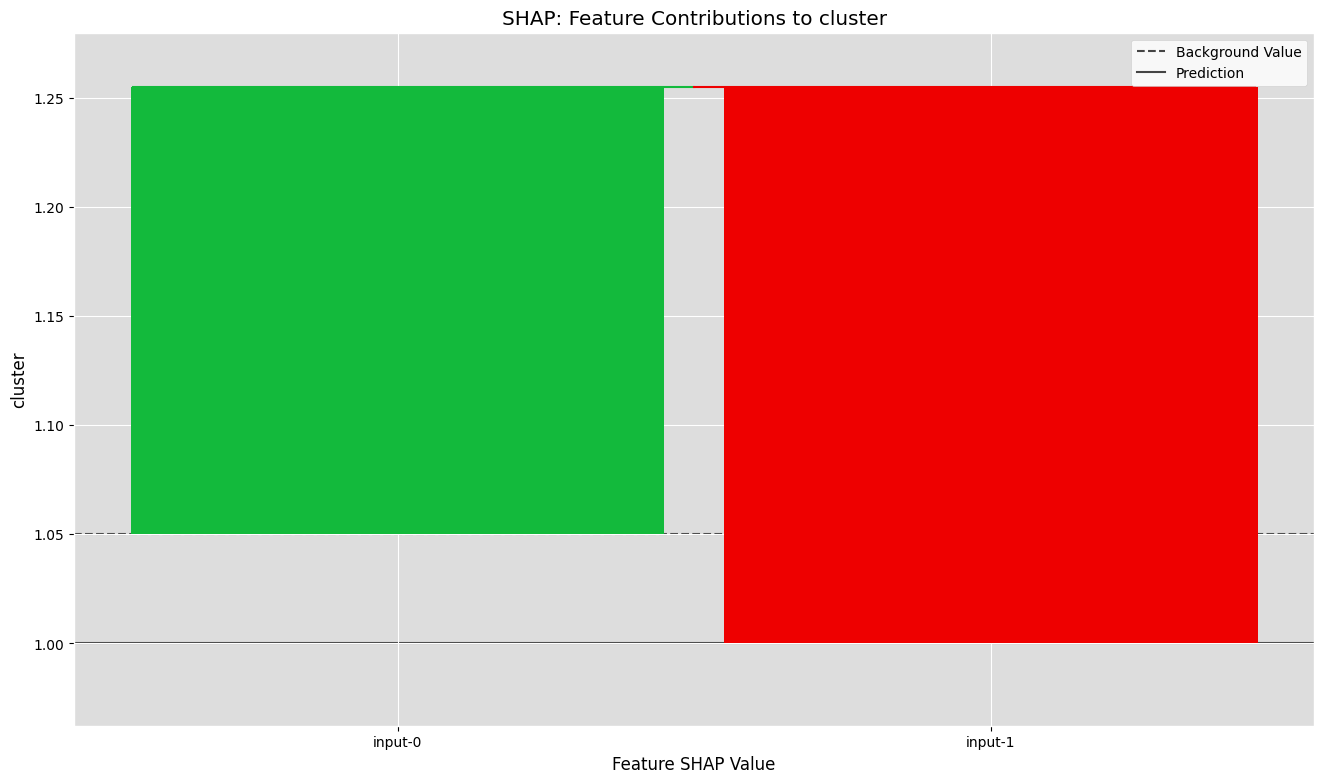

In [27]:
explanations.plot()

# Python model

In [28]:
X, y = datasets.fetch_california_housing(data_home="data", return_X_y=True, as_frame=True)
y = pd.DataFrame(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8)
print(f"X Train: {X_train.shape}, X Test: {X_test.shape}, Y Train: {y_train.shape}, Y Test: {y_test.shape}")


X Train: (16512, 8), X Test: (4128, 8), Y Train: (16512, 1), Y Test: (4128, 1)


In [29]:
xgb_model = xgboost.XGBRegressor(objective='reg:squarederror')
xgb_model.fit(X_train, y_train)
print('Test MSE', xgb_model.score(X_test, y_test))

Test MSE 0.8317831957985719


In [30]:
predictions = xgb_model.predict(X_test)

In [31]:
worst = np.argmax(np.abs(predictions - y_test['MedHouseVal'].values))

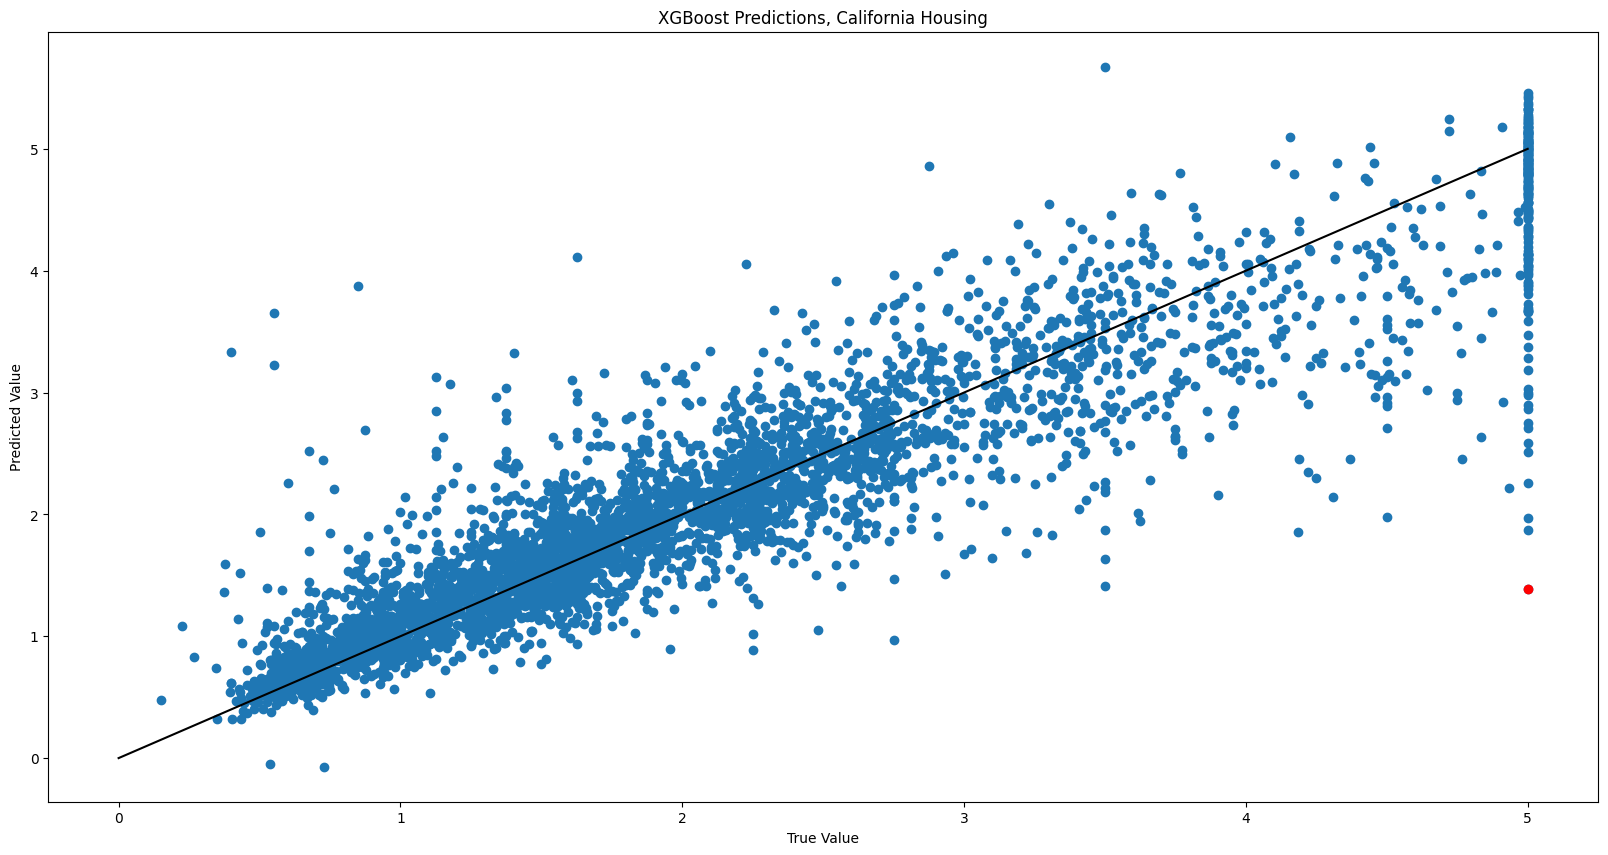

In [32]:
plt.figure(figsize=(20,10))
plt.scatter(y_test, predictions)
plt.scatter(y_test['MedHouseVal'].iloc[worst], predictions[worst], color='r')
plt.plot([0,5], [0,5], color='k')
plt.xlabel("True Value")
plt.ylabel("Predicted Value")
plt.title("XGBoost Predictions, California Housing")
plt.show()

In [33]:
point_to_explain = X_test.iloc[worst]
point_to_explain

MedInc          3.375000
HouseAge        4.000000
AveRooms        3.769953
AveBedrms       1.169014
Population    815.000000
AveOccup        1.913146
Latitude       33.650000
Longitude    -117.580000
Name: 10415, dtype: float64

In [34]:
xgb_model.predict(point_to_explain.to_numpy().reshape(1, -1))

array([1.3885255], dtype=float32)

In [35]:
trustyai_model = Model(xgb_model.predict, dataframe_input=True, output_names=['MedHouseVal'])

In [36]:
feature_domains = [feature_domain(domain) for domain in [
    (0.0, 1000.0), # MedInc
    (1.0, 1000.0), # HouseAge
    (1, 20), # AveRooms
    (1, 20), # AveBedrms
    (1.0, 10_000.0), # Population
    (1.0, 50.0), # AveOccup
    (-90.0, 90.0), # Latitude
    (-180.0, 180.0), # Longitude
]]


In [37]:
goal = [output("MedHouseVal", "number", 5.0)]

In [38]:
explanation = counterfactual.explain(inputs=point_to_explain, goal=goal, feature_domains=feature_domains, model=trustyai_model)

In [39]:
explanation.as_dataframe()

features    proposed    original  constrained  difference
0      MedInc    3.375000    3.375000        False    0.000000
1    HouseAge   26.073921    4.000000        False   22.073921
2    AveRooms    3.769953    3.769953        False    0.000000
3   AveBedrms    1.169014    1.169014        False    0.000000
4  Population  815.000000  815.000000        False    0.000000
5    AveOccup    1.913146    1.913146        False    0.000000
6    Latitude   33.650000   33.650000        False    0.000000
7   Longitude -124.847568 -117.580000        False   -7.267568

In [40]:
feature_domains = [feature_domain(domain) if domain else None for domain in [
    (0.0, 1000.0), # MedInc
    None, # HouseAge
    (1, 20), # AveRooms
    (1, 20), # AveBedrms
    None, # Population
    (1.0, 50.0), # AveOccup
    None, # Latitude
    None, # Longitude
]]

In [41]:
explanation = counterfactual.explain(inputs=point_to_explain, goal=goal, feature_domains=feature_domains, model=trustyai_model)

In [42]:
explanation.as_html()

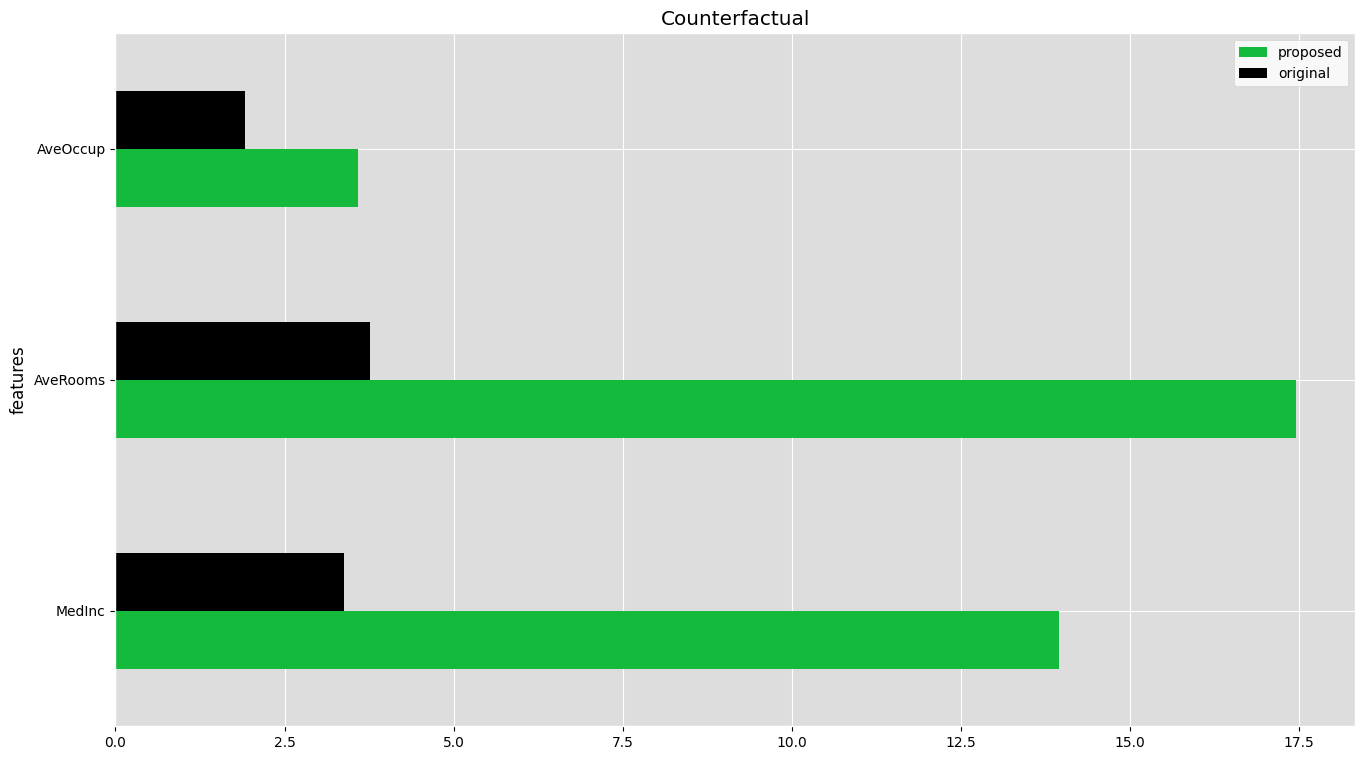

In [43]:
explanation.plot()

In [44]:
new_inputs = explanation.proposed_features_dataframe
prediction = trustyai_model(new_inputs)
prediction

array([4.9930487], dtype=float32)

In [45]:
explanation = lime.explain(inputs=new_inputs, outputs=prediction, model=trustyai_model)

In [46]:
explanation.as_dataframe()['MedHouseVal']

Feature       Value  Saliency  Confidence
0    HouseAge    4.000000  2.084439         0.0
1  Population  815.000000  2.066925         0.0
2    Latitude   33.650000 -0.161738         0.0
3    AveOccup    3.589749 -0.031648         0.0
4    AveRooms   17.459207 -0.042741         0.0
5   Longitude -117.580000  0.069846         0.0

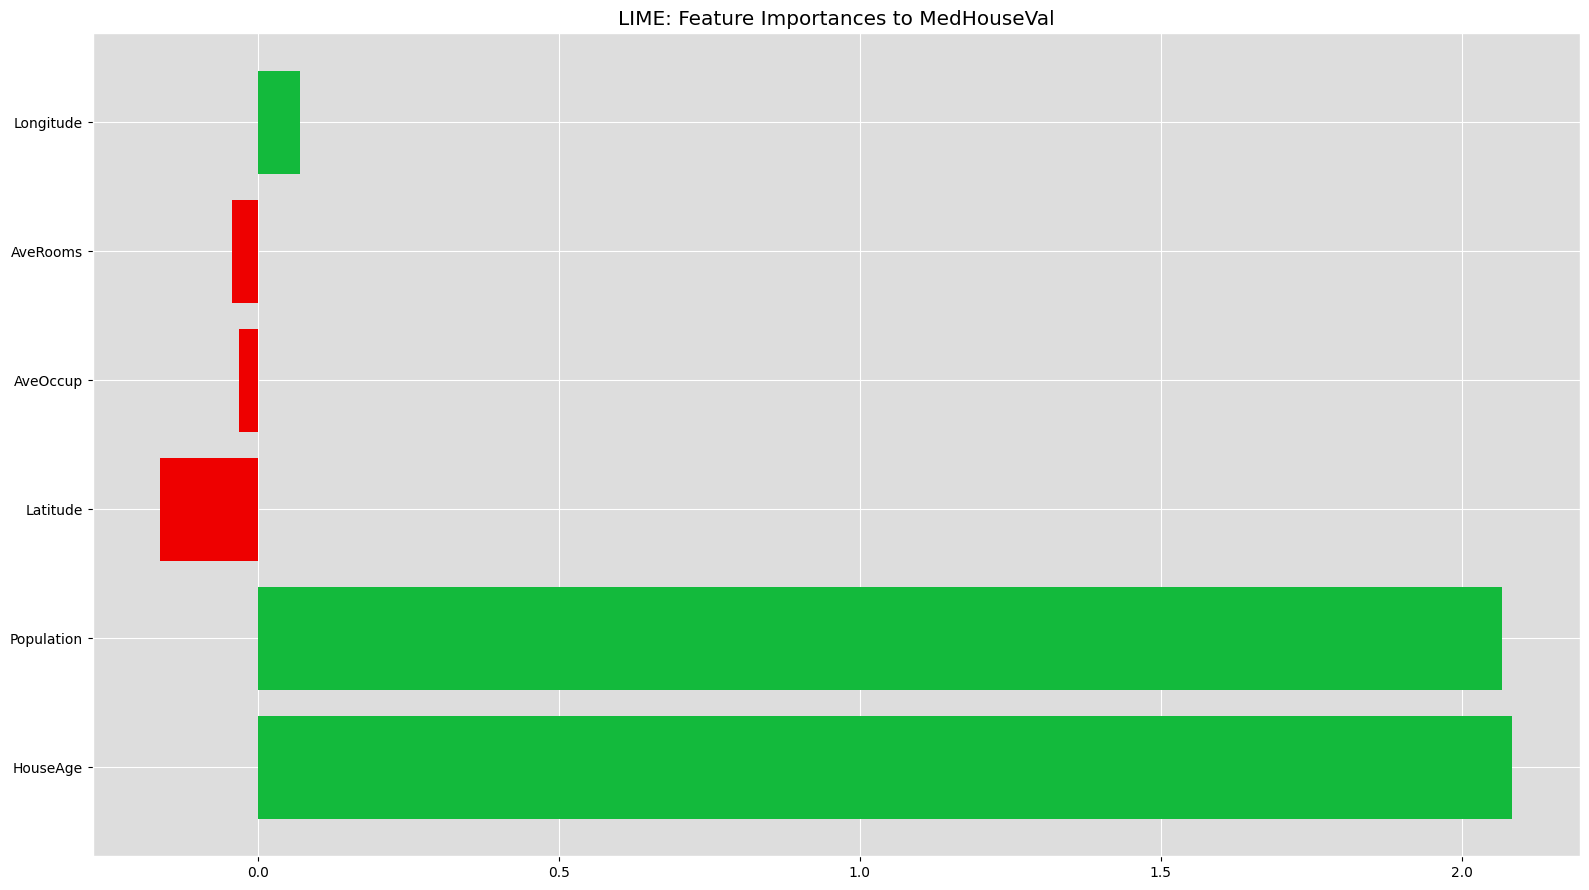

In [47]:
explanation.plot('MedHouseVal')

In [48]:
explainer = SHAPExplainer(background=X_train[:100])

In [49]:
explanations = explainer.explain(inputs=new_inputs, 
                                 outputs=prediction,
                                 model=trustyai_model)

In [50]:
explanations.as_html()['MedHouseVal']

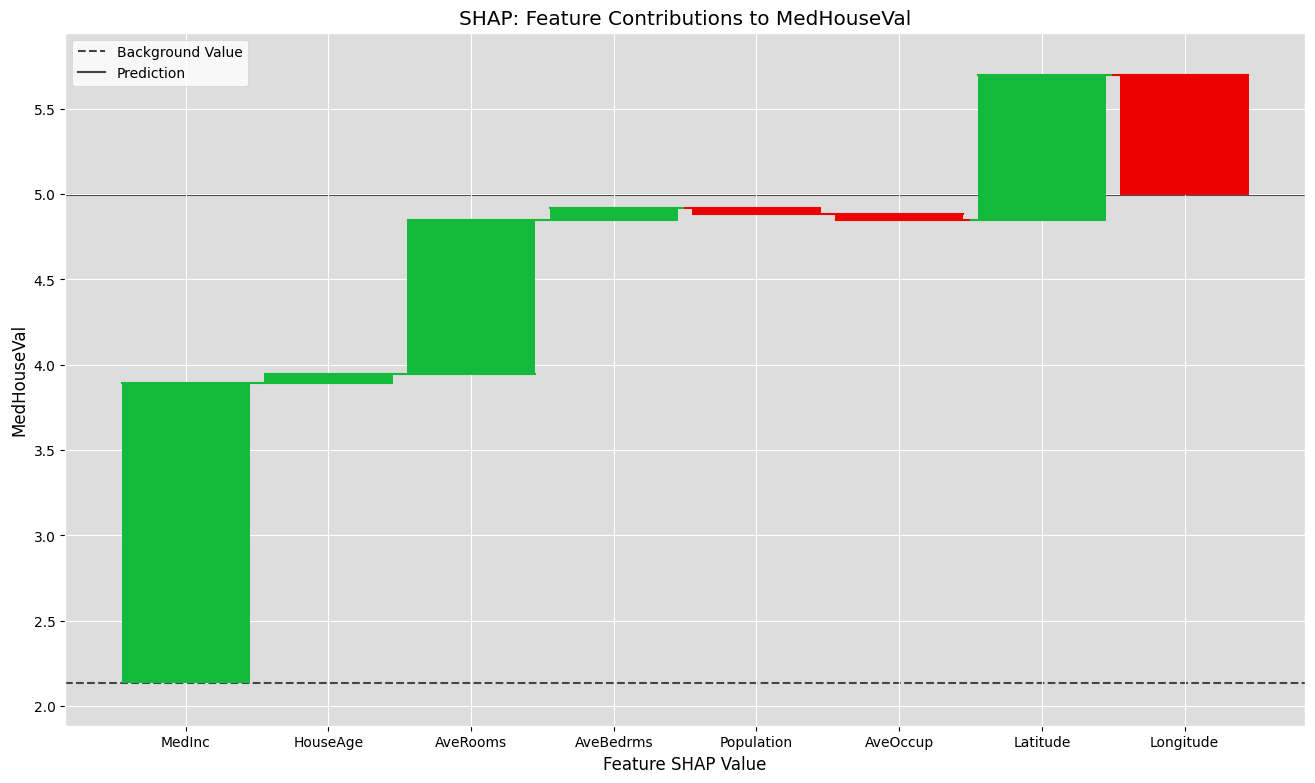

In [51]:
explanations.plot()